Import Library

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import lightgbm as lgb 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

from sklearn.metrics import roc_curve, auc
from scipy.stats import loguniform

Load Data

In [2]:
try:
    train_transformed = pd.read_csv('train_transformed.csv')
    test_transformed = pd.read_csv('test_transformed.csv')
    
    application_test_df = pd.read_csv('application_test.csv')
    test_ids = application_test_df['SK_ID_CURR']
    print("train_transformed, test_transformed, dan test_ids berhasil dimuat.")

except FileNotFoundError:
    print("WARNING: File transformed tidak ditemukan")

gc.collect()

train_transformed, test_transformed, dan test_ids berhasil dimuat.


0

In [3]:
print(f"Loaded train_transformed shape: {train_transformed.shape}")
print(f"Loaded test_transformed shape: {test_transformed.shape}")

Loaded train_transformed shape: (29829, 612)
Loaded test_transformed shape: (48744, 611)


##### 1. Definisikan Fitur (X) dan Target (y)

In [4]:
print("\n--- 1. Mempersiapkan Fitur dan Target (X dan y) ---")
base_feature_cols = [col for col in train_transformed.columns if col not in ['SK_ID_CURR', 'TARGET']]

X_train = train_transformed[base_feature_cols]
y_train = train_transformed['TARGET']
X_test = test_transformed[base_feature_cols]

print(f"X_train initial shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test initial shape: {X_test.shape}")
gc.collect()


--- 1. Mempersiapkan Fitur dan Target (X dan y) ---
X_train initial shape: (29829, 610)
y_train shape: (29829,)
X_test initial shape: (48744, 610)


0

##### 2. Validasi Akhir & Optimasi Tipe Data Fitur

In [5]:
print(f"\n--- 2. Validasi Akhir & Optimasi Tipe Data Fitur ---")

# Identifikasi kolom numerik awal di X_train dan X_test
numeric_cols_train_initial = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_test_initial = X_test.select_dtypes(include=[np.number]).columns.tolist()

# Temukan set AKHIR dari kolom numerik umum yang dimiliki KEDUA dataset
final_feature_columns = list(set(numeric_cols_train_initial) & set(numeric_cols_test_initial))

# Debugging: Periksa jumlah kolom yang umum
print(f"Jumlah kolom numerik di X_train awal: {len(numeric_cols_train_initial)}")
print(f"Jumlah kolom numerik di X_test awal: {len(numeric_cols_test_initial)}")
print(f"Jumlah kolom fitur umum (final_feature_columns): {len(final_feature_columns)}")

# Filter X_train dan X_test untuk hanya menyertakan kolom-kolom ini
X_train = X_train[final_feature_columns]
X_test = X_test[final_feature_columns]

# Pengecekan Kritis: Pastikan jumlah kolom sama setelah filter
if X_train.shape[1] != X_test.shape[1]:
    raise ValueError("ERROR KRITIS: Jumlah kolom X_train dan X_test tidak sama setelah filter!")
if X_train.shape[1] != len(final_feature_columns):
    raise ValueError("ERROR KRITIS: Jumlah kolom X_train tidak cocok dengan daftar final_feature_columns!")

print(f"X_train shape setelah filter final_feature_columns: {X_train.shape}")
print(f"X_test shape setelah filter final_feature_columns: {X_test.shape}")


# Optimalkan Tipe Data Akhir
for col in X_train.columns: # Iterasi melalui kolom X_train, yang sekarang adalah final_feature_columns
    X_train[col] = X_train[col].astype(np.float32)
    X_test[col] = X_test[col].astype(np.float32)

print("Tipe data dioptimalkan")
gc.collect()


--- 2. Validasi Akhir & Optimasi Tipe Data Fitur ---
Jumlah kolom numerik di X_train awal: 594
Jumlah kolom numerik di X_test awal: 594
Jumlah kolom fitur umum (final_feature_columns): 594
X_train shape setelah filter final_feature_columns: (29829, 594)
X_test shape setelah filter final_feature_columns: (48744, 594)
Tipe data dioptimalkan


0

##### 3. Mengambil Sample Data untuk Tuning

In [6]:
print(f"\n--- 3. Mengambil Sampel Data untuk Hyperparameter Tuning ---")
sample_fraction_for_tuning = 0.5 

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=sample_fraction_for_tuning, stratify=y_train, random_state=42
)
print(f"Shape X_train_sample untuk tuning: {X_train_sample.shape}")
gc.collect()


--- 3. Mengambil Sampel Data untuk Hyperparameter Tuning ---
Shape X_train_sample untuk tuning: (14914, 594)


0

##### 4. Inisialisasi LightGBM & Setup Tuning

In [7]:
print("\n--- 4. Inisialisasi Model LightGBM & Setup Tuning ---")

# Hitung scale_pos_weight berdasarkan sampel data untuk tuning
neg_count_sample = (y_train_sample == 0).sum()
pos_count_sample = (y_train_sample == 1).sum()
scale_pos_weight_sample = neg_count_sample / pos_count_sample if pos_count_sample > 0 else 1
print(f"Calculated scale_pos_weight for LightGBM (sample data): {scale_pos_weight_sample:.2f}")

lgbm_base = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42,
                               n_jobs=-1, scale_pos_weight=scale_pos_weight_sample)

# Definisi distribusi parameter untuk Random Search
param_distributions_lgbm = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': loguniform(0.01, 0.1),
    'num_leaves': [20, 31, 40, 60, 80],
    'max_depth': [-1, 10, 15, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': loguniform(1e-5, 1),
    'reg_lambda': loguniform(1e-5, 1),
}

# Strategi Cross-Validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

random_search_lgbm = RandomizedSearchCV(estimator=lgbm_base, param_distributions=param_distributions_lgbm,
                                       n_iter=20, 
                                       scoring='roc_auc',
                                       cv=cv_strategy,
                                       verbose=2, 
                                       random_state=42,
                                       n_jobs=1) 

print("Setup tuning LightGBM selesai.")
gc.collect()


--- 4. Inisialisasi Model LightGBM & Setup Tuning ---
Calculated scale_pos_weight for LightGBM (sample data): 11.50
Setup tuning LightGBM selesai.


0

##### 5. Hyperparameter Tuning (Fit RandomizedSearchCV)

In [8]:
print("\n--- 5. Memulai Hyperparameter Tuning LightGBM (Random Search) ---")

# Memisahkan data sampel untuk pelatihan tuning dan validasi early stopping
X_train_fit_for_tuning, X_val_fit_for_tuning, y_train_fit_for_tuning, y_val_fit_for_tuning = train_test_split(
    X_train_sample, y_train_sample, test_size=0.5, random_state=42, stratify=y_train_sample
)
print(f"Shape X_train_fit_for_tuning: {X_train_fit_for_tuning.shape}")
print(f"Shape X_val_fit_for_tuning: {X_val_fit_for_tuning.shape}")



--- 5. Memulai Hyperparameter Tuning LightGBM (Random Search) ---
Shape X_train_fit_for_tuning: (7457, 594)
Shape X_val_fit_for_tuning: (7457, 594)


In [9]:
random_search_lgbm.fit(X_train_fit_for_tuning, y_train_fit_for_tuning,
                       eval_set=[(X_val_fit_for_tuning, y_val_fit_for_tuning)],
                       eval_metric='auc',
                       callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
                      )

print("Hyperparameter Tuning LightGBM selesai.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 477, number of negative: 5488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82995
[LightGBM] [Info] Number of data points in the train set: 5965, number of used features: 527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079966 -> initscore=-2.442803
[LightGBM] [Info] Start training from score -2.442803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

##### 6. Hasil Tuning Terbaik

In [10]:
print("\n--- 6. Hasil Tuning LightGBM ---")
best_params = random_search_lgbm.best_params_ 
best_cv_auc = random_search_lgbm.best_score_ 

print("Best parameters found: ", best_params)
print("Best ROC AUC score (on sample data, cross-validated): ", best_cv_auc)


--- 6. Hasil Tuning LightGBM ---
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': np.float64(0.019753028295106112), 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 60, 'reg_alpha': np.float64(0.10431827200054895), 'reg_lambda': np.float64(8.567424667875054e-05), 'subsample': 0.8}
Best ROC AUC score (on sample data, cross-validated):  0.7329625217433913


##### 7. Visualisasi ROC-AUC dari model terbaik pada validasi sample


--- 7. Visualisasi ROC AUC ---
ROC AUC Score on specific validation set for plot: 0.7255


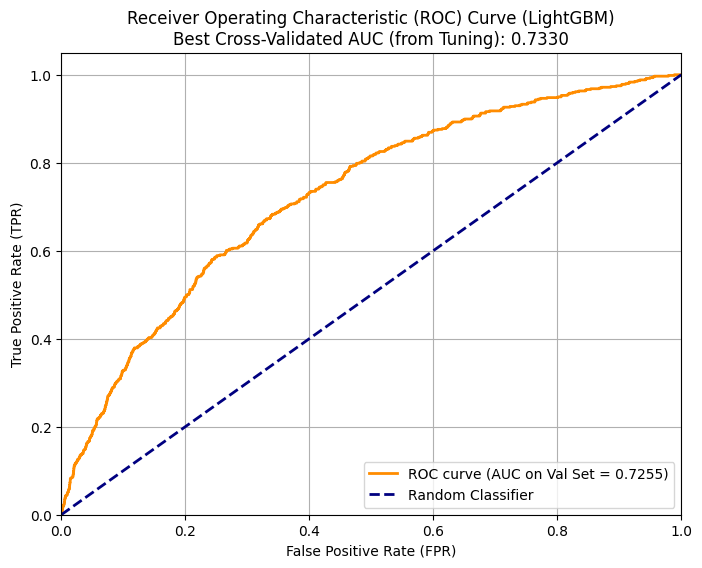

In [11]:
print("\n--- 7. Visualisasi ROC AUC ---")

# Dapatkan probabilitas prediksi dari model terbaik pada data validasi yang digunakan saat tuning
y_val_pred_proba = random_search_lgbm.best_estimator_.predict_proba(X_val_fit_for_tuning)[:, 1]

# Hitung False Positive Rate (FPR), True Positive Rate (TPR), dan Thresholds
fpr, tpr, thresholds = roc_curve(y_val_fit_for_tuning, y_val_pred_proba)

# Hitung Area Under the Curve (AUC) untuk kurva yang diplot
roc_auc_for_plot = auc(fpr, tpr)

print(f"ROC AUC Score on specific validation set for plot: {roc_auc_for_plot:.4f}")

# Plot Kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC on Val Set = {roc_auc_for_plot:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'Receiver Operating Characteristic (ROC) Curve (LightGBM)\n'
          f'Best Cross-Validated AUC (from Tuning): {best_cv_auc:.4f}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

##### 8. Training model LightGBM dengan parameter terbaik pada seluruh data train

In [12]:
print("\n--- 8. Melatih Model LightGBM Final pada SELURUH Data Train ---")

# Hitung scale_pos_weight untuk SELURUH data training
neg_count_full = (y_train == 0).sum()
pos_count_full = (y_train == 1).sum()
scale_pos_weight_full = neg_count_full / pos_count_full if pos_count_full > 0 else 1
print(f"Calculated scale_pos_weight for FULL training data: {scale_pos_weight_full:.2f}")

# Inisialisasi model LightGBM baru dengan parameter terbaik dan scale_pos_weight yang dihitung dari data training penuh
final_lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1, 
    scale_pos_weight=scale_pos_weight_full,
    **best_params 
)

# Training model final pada SELURUH data train (X_train dan y_train)
print(f"Memulai pelatihan model final pada X_train.shape: {X_train.shape}")
final_lgbm_model.fit(X_train, y_train) 
print("Pelatihan model final selesai.")
gc.collect()



--- 8. Melatih Model LightGBM Final pada SELURUH Data Train ---
Calculated scale_pos_weight for FULL training data: 11.50
Memulai pelatihan model final pada X_train.shape: (29829, 594)
[LightGBM] [Info] Number of positive: 2387, number of negative: 27442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90235
[LightGBM] [Info] Number of data points in the train set: 29829, number of used features: 532
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080023 -> initscore=-2.442037
[LightGBM] [Info] Start training from score -2.442037
Pelatihan model final selesai.


3153

##### 9. Membuat prediksi pada Data Test dengan model final

In [13]:
print("\n--- 9. Membuat Prediksi pada Data Uji dengan Model Final ---")
test_preds = final_lgbm_model.predict_proba(X_test)[:, 1]
print("Prediksi pada data uji selesai.")


--- 9. Membuat Prediksi pada Data Uji dengan Model Final ---
Prediksi pada data uji selesai.


##### 10. Create file submission

In [14]:
print("\n--- 10. Membuat File Submission ---")
submission_df = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_preds})
submission_filename = 'submission_lightgbm.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\nFile submission '{submission_filename}' berhasil dibuat.")


--- 10. Membuat File Submission ---

File submission 'submission_lightgbm.csv' berhasil dibuat.


Menggunakan threshold = 0.5 untuk mengklasifikasikan probabilitas.

Jumlah prediksi untuk setiap kelas:
PREDICTED_CLASS
0    46768
1     1976
Name: count, dtype: int64

Persentase prediksi untuk setiap kelas:
PREDICTED_CLASS
0    95.95
1     4.05
Name: proportion, dtype: float64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5636\1053802483.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


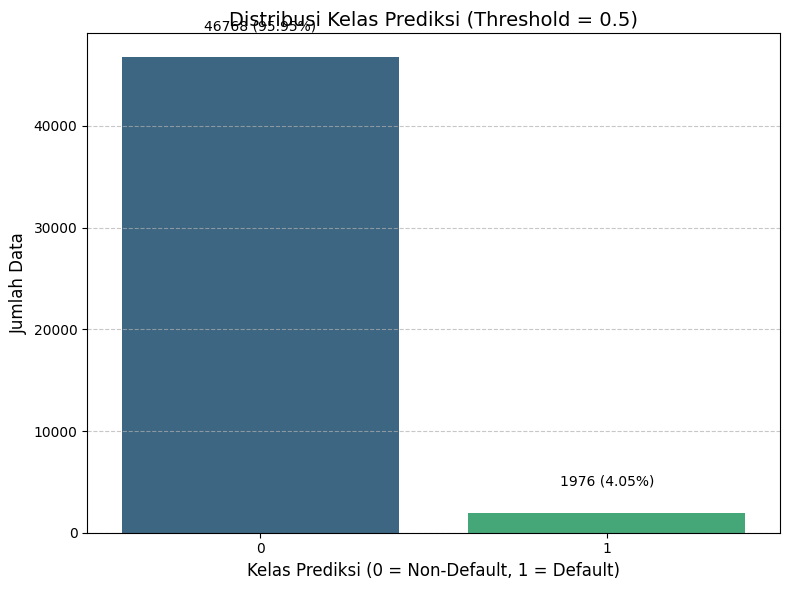

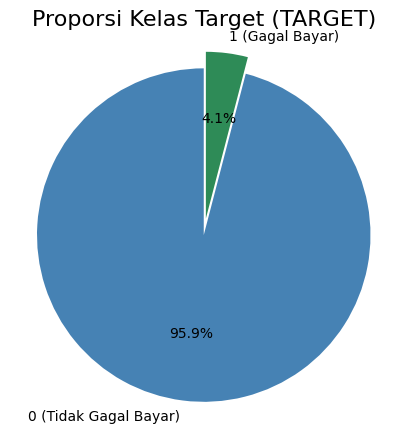

In [15]:
import seaborn as sns 

threshold = 0.5
print(f"Menggunakan threshold = {threshold} untuk mengklasifikasikan probabilitas.")

# Buat Kolom 'PREDICTED_CLASS' 
submission_df['PREDICTED_CLASS'] = (submission_df['TARGET'] > threshold).astype(int)

# Hitung Jumlah Kemunculan Setiap Kelas 
class_counts = submission_df['PREDICTED_CLASS'].value_counts().sort_index()
class_percentages = submission_df['PREDICTED_CLASS'].value_counts(normalize=True).sort_index() * 100

print("\nJumlah prediksi untuk setiap kelas:")
print(class_counts)
print("\nPersentase prediksi untuk setiap kelas:")
print(class_percentages.round(2)) 

# Visualisasi Bar Plot 
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Tambahkan label nilai
for index, value in enumerate(class_counts.values):
    plt.text(index, value + 0.05 * max(class_counts.values),
             f'{value} ({class_percentages.iloc[index]:.2f}%)',
             ha='center', va='bottom', fontsize=10)

plt.title(f'Distribusi Kelas Prediksi (Threshold = {threshold})', fontsize=14)
plt.xlabel('Kelas Prediksi (0 = Non-Default, 1 = Default)', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualisasi Pie Chart
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['0 (Tidak Gagal Bayar)', '1 (Gagal Bayar)'],
        autopct='%1.1f%%', startangle=90, colors=['steelblue','seagreen'], explode=(0, 0.1))
plt.title('Proporsi Kelas Target (TARGET)', fontsize=16)
plt.axis('equal') 
plt.show()


Menghitung metrik dengan ambang batas (threshold) = 0.5
Accuracy:  0.8935
Precision: 0.2500
Recall:    0.1661
F1-Score:  0.1996
ROC AUC:   0.7255


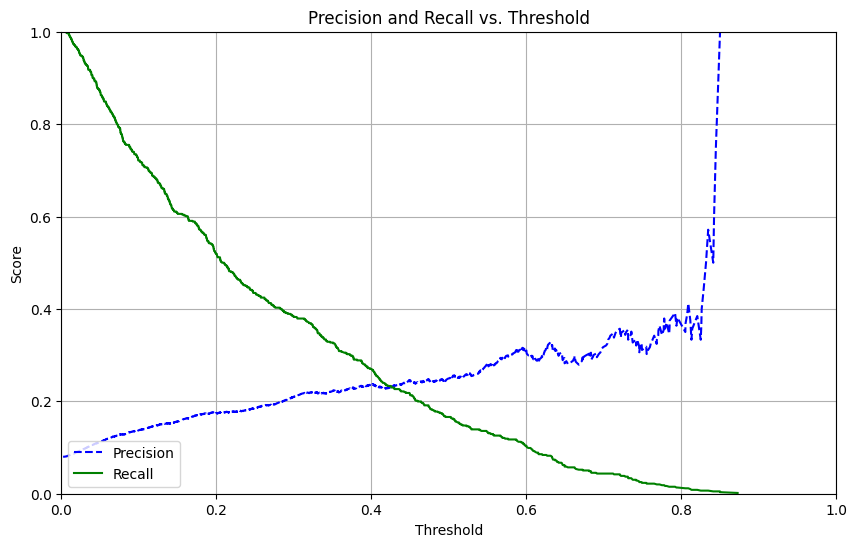

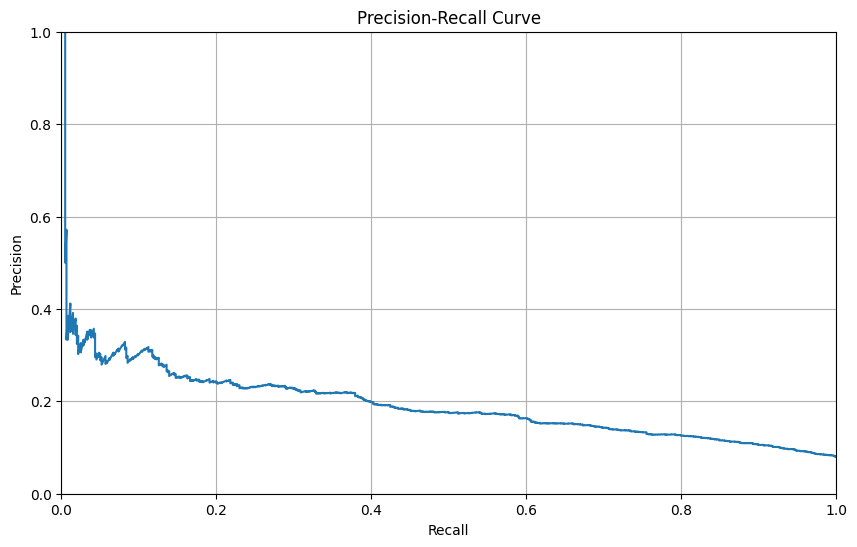

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

threshold = 0.5
print(f"\nMenghitung metrik dengan ambang batas (threshold) = {threshold}")

# Konversi Probabilitas menjadi Kelas Biner 
y_pred_binary = (y_val_pred_proba > threshold).astype(int)

# Hitung Metrik Evaluasi 
accuracy = accuracy_score(y_val_fit_for_tuning, y_pred_binary)
precision = precision_score(y_val_fit_for_tuning, y_pred_binary)
recall = recall_score(y_val_fit_for_tuning, y_pred_binary)
f1 = f1_score(y_val_fit_for_tuning, y_pred_binary)

# ROC AUC tidak memerlukan ambang batas, dihitung langsung dari probabilitas
roc_auc = roc_auc_score(y_val_fit_for_tuning, y_val_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

## Visualisasi Trade-off Precision-Recall

from sklearn.metrics import precision_recall_curve

# Hitung Precision, Recall, dan Thresholds untuk berbagai titik pada kurva
precisions, recalls, thresholds = precision_recall_curve(y_val_fit_for_tuning, y_val_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Plot Kurva Precision-Recall
# menunjukkan trade-off langsung antara Precision dan Recall
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()